# Oblique 3D Terrain Visualization with rtxpy

This notebook demonstrates how to create oblique 3D terrain visualizations using rtxpy's GPU-accelerated hillshade rendering.

We'll download real USGS elevation data and render transformed `xarray.DataArray` obejcts using `mpl_toolkits.mplot3d.Axes3D`

## What You'll Learn

1. **Dynamic terrain download** from USGS elevation services
2. **GPU-accelerated hillshading** with shadow casting
3. **Oblique 3D terrain rendering** with matplotlib
4. **Color blending techniques** for eye-catching visualizations
5. **Multiple lighting scenarios** (sunrise, noon, sunset)

---

Our showcase location: **Mount Rainier, Washington** - an iconic volcanic peak rising 14,411 feet above sea level.

## 1. Setup and Imports

In [1]:
# Core imports
import numpy as np
import cupy as cp
import xarray as xr
import rioxarray as rxr
import requests
from pathlib import Path
import math

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, LinearSegmentedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# rtxpy for GPU-accelerated hillshade
# The accessor is automatically registered when importing rtxpy
import rtxpy

print(f"CuPy version: {cp.__version__}")
print(f"CUDA version: {cp.cuda.runtime.runtimeGetVersion()}")
print(f"rtxpy version: {rtxpy.__version__}")
print("\nGPU terrain visualization ready!")

CuPy version: 13.6.0
CUDA version: 13000
rtxpy version: 0.0.5

GPU terrain visualization ready!


## 2. Download Real Terrain Data

We'll download SRTM 1-arc-second (~30m) elevation data from the USGS National Map. This is the same high-quality data used by cartographers and GIS professionals.

In [2]:
def download_terrain(bounds, output_path):
    """
    Download SRTM 1-arc-second elevation data from USGS.

    Parameters
    ----------
    bounds : tuple
        (west, south, east, north) in WGS84 degrees
    output_path : Path
        Where to save the clipped DEM

    Returns
    -------
    xarray.DataArray
        Elevation data in meters
    """
    from rioxarray.merge import merge_arrays

    west, south, east, north = bounds

    # Determine which 1x1 degree tiles we need
    # USGS naming: tile "n47w122" covers lat 46-47, lon -122 to -121
    # The number is the UPPER (north) boundary for latitude
    # and the absolute value of the WEST boundary for longitude
    lat_min, lat_max = math.floor(south) + 1, math.floor(north) + 1
    lon_min, lon_max = math.floor(west), math.floor(east)

    base_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current"
    tile_paths = []

    print("Downloading SRTM elevation data...")

    for lat in range(lat_min, lat_max + 1):
        for lon in range(lon_min, lon_max + 1):
            ns = "n" if lat > 0 else "s"
            ew = "w" if lon < 0 else "e"
            tile_name = f"{ns}{abs(lat):02d}{ew}{abs(lon):03d}"
            url = f"{base_url}/{tile_name}/USGS_1_{tile_name}.tif"
            tile_path = output_path.parent / f"USGS_1_{tile_name}.tif"

            if not tile_path.exists():
                print(f"  Downloading {tile_name}...")
                resp = requests.get(url, timeout=120)
                resp.raise_for_status()
                tile_path.write_bytes(resp.content)
            else:
                print(f"  Using cached {tile_name}")
            tile_paths.append(tile_path)

    # Merge tiles and clip to bounds
    tiles = [rxr.open_rasterio(str(p), masked=True).squeeze() for p in tile_paths]
    merged = merge_arrays(tiles) if len(tiles) > 1 else tiles[0]
    clipped = merged.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
    clipped.rio.to_raster(str(output_path))

    print(f"  Saved to {output_path}")
    return clipped

In [3]:
# Mount Rainier area - centered on the summit
# This captures the dramatic volcanic peak and surrounding glaciers
BOUNDS = (-121.85, 46.78, -121.65, 46.92)  # ~18km x 16km area
DEM_PATH = Path.cwd() / "mt_rainier_dem.tif"

if not DEM_PATH.exists():
    terrain = download_terrain(BOUNDS, DEM_PATH)
else:
    print(f"Using existing DEM: {DEM_PATH}")
    terrain = rxr.open_rasterio(str(DEM_PATH), masked=True).squeeze()

# Get terrain info
H, W = terrain.shape
elev_min, elev_max = float(np.nanmin(terrain.data)), float(np.nanmax(terrain.data))

print(f"\nTerrain loaded:")
print(f"  Shape: {H} x {W} pixels")
print(f"  Resolution: ~30m per pixel")
print(f"  Elevation range: {elev_min:.0f}m to {elev_max:.0f}m")
print(f"  Total relief: {elev_max - elev_min:.0f}m ({(elev_max - elev_min) * 3.281:.0f} ft)")

  Saved to /home/brendan/rtxpy/examples/mt_rainier_dem.tif

Terrain loaded:
  Shape: 505 x 721 pixels
  Resolution: ~30m per pixel
  Elevation range: 995m to 4392m
  Total relief: 3397m (11145 ft)


## 3. Quick Preview

Let's take a first look at our terrain data with basic coloring.

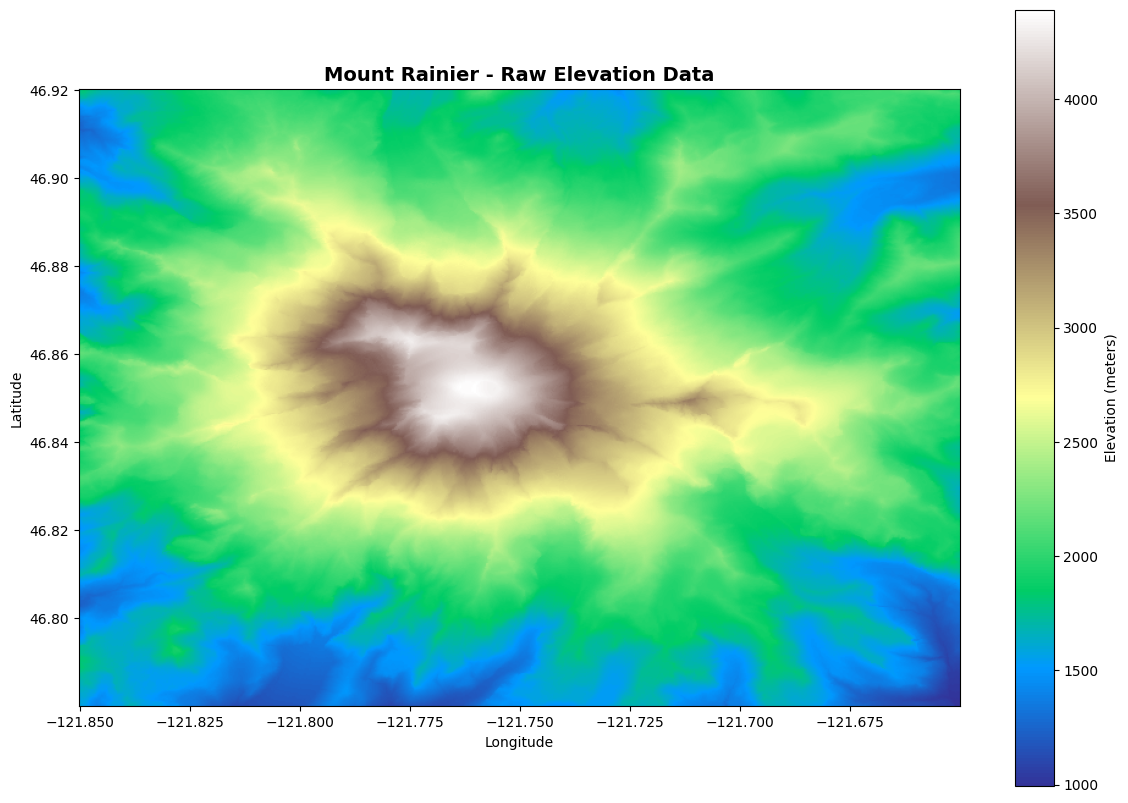

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))

# Use a terrain colormap
im = ax.imshow(terrain.data, cmap='terrain',
               extent=[float(terrain.x.min()), float(terrain.x.max()),
                       float(terrain.y.min()), float(terrain.y.max())])

ax.set_title('Mount Rainier - Raw Elevation Data', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(im, ax=ax, label='Elevation (meters)', shrink=0.8)
plt.tight_layout()
plt.show()

## 4. GPU-Accelerated Hillshade

Now let's use rtxpy's ray-traced hillshade to add dramatic lighting. The GPU performs millions of ray intersections to calculate accurate shadows and shading.

We'll use the **xarray accessor** which provides a clean API:
- `terrain.rtx.to_cupy()` - Convert data to GPU memory
- `terrain_gpu.rtx.hillshade()` - Compute GPU-accelerated hillshade

The accessor automatically caches the RTX instance, so subsequent calls reuse the same acceleration structure.

In [8]:
%matplotlib qt

terrain.rtx.explore()


Keyboard controls will NOT work with the inline backend.

To fix, run this BEFORE calling explore():
    %matplotlib qt
  OR
    %matplotlib tk
  OR (if ipympl is installed):
    %matplotlib widget

Then restart the kernel and run the notebook again.



/home/brendan/rtxpy/rtxpy/analysis/render.py:624: UserWarning: raster.data is not a cupy array. Additional overhead will be incurred from CPU-GPU transfers.
  warnings.warn(



Interactive Viewer Started
  Window: 800x600
  Render: 400x300 (50%)
  Terrain: 721x505, elevation 995m - 4392m

Press H for controls, X or Esc to exit

Colormap: viridis
Colormap: plasma
Colormap: cividis
Colormap: gray
Colormap: terrain
Viewer closed after 662 frames


## 5. Sunrise to Sunset

The sun angle dramatically changes how terrain looks. Let's render the mountain at different times of day.

In [ ]:
# Different lighting conditions
lighting_configs = [
    {'name': 'Dawn (East)', 'azimuth': 90, 'altitude': 15},
    {'name': 'Morning (Southeast)', 'azimuth': 135, 'altitude': 30},
    {'name': 'Noon (South)', 'azimuth': 180, 'altitude': 60},
    {'name': 'Afternoon (Southwest)', 'azimuth': 225, 'altitude': 35},
    {'name': 'Evening (West)', 'azimuth': 270, 'altitude': 20},
    {'name': 'Classic NW', 'azimuth': 315, 'altitude': 45},
]

fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()

for i, config in enumerate(lighting_configs):
    print(f"Rendering {config['name']}...")
    # Use the accessor for hillshade - RTX instance is cached automatically
    hs_temp = terrain_gpu.rtx.hillshade(
        shadows=True, 
        azimuth=config['azimuth'], 
        angle_altitude=config['altitude']
    )
    hs_temp_data = hs_temp.data.get() if hasattr(hs_temp.data, 'get') else hs_temp.data
    # Apply subtle shadow lift
    hs_temp_data = shadow_lift + (1 - shadow_lift) * hs_temp_data
    
    axes[i].imshow(hs_temp_data, cmap='gray')
    axes[i].set_title(f"{config['name']}\nAz: {config['azimuth']}° Alt: {config['altitude']}°", 
                      fontsize=11)
    axes[i].axis('off')

plt.suptitle('Mount Rainier Lighting Study', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Oblique 3D Terrain Visualization

Now for the main event: creating stunning oblique 3D views of Mount Rainier. We'll render the terrain as a 3D surface with our GPU-computed hillshade draped over it.

In [ ]:
# Subsample for 3D performance (every 4th pixel)
subsample = 4
elev_data = terrain.data
if hasattr(elev_data, 'get'):
    elev_data = elev_data.get()

Z = elev_data[::subsample, ::subsample]
H_sub, W_sub = Z.shape

# Create coordinate grids using actual geographic coordinates for proper aspect
x_coords = terrain.x.values[::subsample]
y_coords = terrain.y.values[::subsample]
X, Y = np.meshgrid(x_coords, y_coords)

# Calculate real-world dimensions for proper aspect ratio
# At this latitude, adjust for longitude compression
lat_center = (float(terrain.y.min()) + float(terrain.y.max())) / 2
lon_scale = np.cos(np.radians(lat_center))  # Longitude compression factor

x_range = float(terrain.x.max()) - float(terrain.x.min())
y_range = float(terrain.y.max()) - float(terrain.y.min())

# Real aspect: x needs to be scaled by cos(lat), then compared to y
real_x_extent = x_range * lon_scale * 111  # km (approx)
real_y_extent = y_range * 111  # km (approx)

# Get hillshade for coloring (subsample to match)
hs_sub = hs_data[::subsample, ::subsample]

# Create figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with hillshade coloring
# Normalize hillshade for colormap
hs_norm = np.nan_to_num(hs_sub, nan=0.5)

# Create a custom colormap from hillshade
colors = cm.gray(hs_norm)

surf = ax.plot_surface(X, Y, Z, facecolors=colors,
                       rstride=1, cstride=1,
                       antialiased=True, shade=False)

# Set viewing angle for dramatic oblique view
ax.view_init(elev=35, azim=-120)

# Adjust z-axis for better proportions (vertical exaggeration ~2x)
z_range = np.nanmax(Z) - np.nanmin(Z)
# Use real-world proportions for x and y, with vertical exaggeration
vert_exag = 2.0  # Vertical exaggeration factor
z_scale = (z_range / 1000) * vert_exag / max(real_x_extent, real_y_extent)  # Convert m to km
ax.set_box_aspect([real_x_extent, real_y_extent, z_scale * max(real_x_extent, real_y_extent)])

ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)
ax.set_zlabel('Elevation (m)', fontsize=10)
ax.set_title('Mount Rainier - Oblique 3D View\n(NW illumination with ray-traced shadows)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Real-world extents: {real_x_extent:.1f} km (E-W) x {real_y_extent:.1f} km (N-S)")

## 7. Multiple Oblique Views

Let's create views from different angles around the mountain.

In [ ]:
# Views from different directions
views = [
    {'name': 'View from South', 'elev': 30, 'azim': 0},
    {'name': 'View from Southwest', 'elev': 35, 'azim': -45},
    {'name': 'View from West', 'elev': 25, 'azim': -90},
    {'name': 'View from Northwest', 'elev': 35, 'azim': -135},
]

fig = plt.figure(figsize=(16, 14))

# Calculate aspect ratio for all views
aspect = [real_x_extent, real_y_extent, z_scale * max(real_x_extent, real_y_extent)]

for i, view in enumerate(views, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, facecolors=colors,
                           rstride=1, cstride=1,
                           antialiased=True, shade=False)
    
    ax.view_init(elev=view['elev'], azim=view['azim'])
    ax.set_box_aspect(aspect)
    ax.set_title(view['name'], fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zticks([])

plt.suptitle('Mount Rainier from All Angles', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Vary the colormap

Now let's create some truly stunning visualizations by combining hillshade with elevation-based coloring and other artistic effects.

In [ ]:
# Define custom colormaps for different effects

# Alpine colormap: green valleys -> brown slopes -> white peaks
alpine_colors = [
    (0.0, '#1a472a'),   # Dark forest green (lowest)
    (0.2, '#2d5a3f'),   # Forest green
    (0.35, '#6b8e23'),  # Olive/meadow
    (0.5, '#8b7355'),   # Brown rocky slopes
    (0.65, '#a0917a'),  # Light brown/scree
    (0.8, '#c4b8a8'),   # Gray rock
    (0.9, '#e8e4e0'),   # Light gray/snow patches
    (1.0, '#ffffff'),   # Pure white (summit snow)
]
alpine_cmap = LinearSegmentedColormap.from_list('alpine', alpine_colors)

# Sunset colormap: warm atmospheric tones
sunset_colors = [
    (0.0, '#1a1a2e'),   # Deep blue shadow
    (0.3, '#4a3f6b'),   # Purple
    (0.5, '#8b4d6b'),   # Rose
    (0.7, '#d4886a'),   # Salmon
    (0.85, '#f4a460'),  # Sandy orange
    (1.0, '#ffd700'),   # Gold highlights
]
sunset_cmap = LinearSegmentedColormap.from_list('sunset', sunset_colors)

# Ice colormap: glacial tones
ice_colors = [
    (0.0, '#0a1628'),   # Deep navy
    (0.2, '#1a3a5c'),   # Dark blue
    (0.4, '#3d6b8a'),   # Steel blue
    (0.6, '#6ba3c2'),   # Light blue
    (0.8, '#a8d4e6'),   # Ice blue
    (1.0, '#e8f4f8'),   # Glacier white
]
ice_cmap = LinearSegmentedColormap.from_list('ice', ice_colors)

print("Custom colormaps created!")

In [ ]:
def blend_hillshade_with_color(elevation, hillshade_data, colormap, blend=0.6):
    """
    Blend elevation-based color with hillshade for beautiful terrain rendering.
    
    Parameters
    ----------
    elevation : array
        Elevation data
    hillshade_data : array
        Hillshade values (0-1)
    colormap : Colormap
        Matplotlib colormap for elevation
    blend : float
        Blend factor (0 = pure color, 1 = pure hillshade)
    
    Returns
    -------
    array
        RGBA image
    """
    # Normalize elevation to 0-1
    elev_norm = (elevation - np.nanmin(elevation)) / (np.nanmax(elevation) - np.nanmin(elevation))
    elev_norm = np.nan_to_num(elev_norm, nan=0)
    
    # Get colors from colormap
    colors = colormap(elev_norm)
    
    # Normalize hillshade
    hs_norm = np.nan_to_num(hillshade_data, nan=0.5)
    
    # Blend: multiply RGB by hillshade intensity
    blended = colors.copy()
    for i in range(3):  # RGB channels
        blended[:, :, i] = colors[:, :, i] * (1 - blend + blend * hs_norm)
    
    return blended

In [ ]:
# Create artistic 2D renderings
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

elev_data_np = terrain.data if isinstance(terrain.data, np.ndarray) else terrain.data.get()

# 1. Alpine style
alpine_render = blend_hillshade_with_color(elev_data_np, hs_data, alpine_cmap, blend=0.5)
axes[0, 0].imshow(alpine_render)
axes[0, 0].set_title('Alpine Natural', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. Sunset atmosphere
# Use a warmer hillshade with low sun angle via the accessor
hs_sunset_raw = terrain_gpu.rtx.hillshade(shadows=True, azimuth=270, angle_altitude=15)
hs_sunset_data = hs_sunset_raw.data.get() if hasattr(hs_sunset_raw.data, 'get') else hs_sunset_raw.data
# Apply subtle shadow lift
hs_sunset_data = shadow_lift + (1 - shadow_lift) * hs_sunset_data
sunset_render = blend_hillshade_with_color(elev_data_np, hs_sunset_data, sunset_cmap, blend=0.55)
axes[0, 1].imshow(sunset_render)
axes[0, 1].set_title('Golden Hour', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. Glacial/Ice style
ice_render = blend_hillshade_with_color(elev_data_np, hs_data, ice_cmap, blend=0.45)
axes[1, 0].imshow(ice_render)
axes[1, 0].set_title('Glacial Blue', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 4. High contrast dramatic (use original raw hillshade for more drama here)
hs_dramatic = np.clip((hs_raw_data - 0.2) * 1.5, 0, 1)
dramatic_render = blend_hillshade_with_color(elev_data_np, hs_dramatic, cm.copper, blend=0.65)
axes[1, 1].imshow(dramatic_render)
axes[1, 1].set_title('Dramatic Copper', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle('Mount Rainier - Artistic Terrain Styles', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Colored Oblique 3D Views

Let's combine everything: oblique 3D rendering with our artistic color schemes.

In [ ]:
# Subsample the artistic renders
alpine_sub = alpine_render[::subsample, ::subsample]
sunset_sub = sunset_render[::subsample, ::subsample]

fig = plt.figure(figsize=(18, 8))

# Aspect with slightly more vertical exaggeration for drama
aspect_dramatic = [real_x_extent, real_y_extent, z_scale * max(real_x_extent, real_y_extent) * 1.25]

# Alpine 3D
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z, facecolors=alpine_sub,
                         rstride=1, cstride=1,
                         antialiased=True, shade=False)
ax1.view_init(elev=30, azim=-135)
ax1.set_box_aspect(aspect_dramatic)
ax1.set_title('Alpine Natural Style', fontsize=14, fontweight='bold')
ax1.axis('off')

# Sunset 3D
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z, facecolors=sunset_sub,
                         rstride=1, cstride=1,
                         antialiased=True, shade=False)
ax2.view_init(elev=25, azim=-100)
ax2.set_box_aspect(aspect_dramatic)
ax2.set_title('Golden Hour Style', fontsize=14, fontweight='bold')
ax2.axis('off')

plt.suptitle('Mount Rainier - Oblique 3D Terrain Art', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 10. The Hero Shot

One final dramatic view combining all our techniques for a publication-quality render.

In [ ]:
# Create the ultimate hero shot
fig = plt.figure(figsize=(20, 14))

# Main 3D view takes up most of the space
ax_main = fig.add_subplot(111, projection='3d')

# Use alpine coloring for the hero shot
surf = ax_main.plot_surface(X, Y, Z, facecolors=alpine_sub,
                            rstride=1, cstride=1,
                            antialiased=True, shade=False,
                            linewidth=0)

# Perfect viewing angle
ax_main.view_init(elev=28, azim=-125)

# Adjust proportions for dramatic effect (more vertical exaggeration)
aspect_hero = [real_x_extent, real_y_extent, z_scale * max(real_x_extent, real_y_extent) * 1.5]
ax_main.set_box_aspect(aspect_hero)

# Clean up axes
ax_main.set_axis_off()

# Add title with stats
title_text = (
    f"Mount Rainier, Washington\n"
    f"Summit: {elev_max:.0f}m ({elev_max * 3.281:.0f} ft)  |  "
    f"Relief: {elev_max - elev_min:.0f}m  |  "
    f"GPU Ray-Traced Hillshade with Cast Shadows"
)
ax_main.text2D(0.5, 0.95, title_text, transform=ax_main.transAxes,
               fontsize=14, ha='center', va='top',
               fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('mt_rainier_hero.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("\nHero shot saved to 'mt_rainier_hero.png'")

## 11. Bonus: Contour Lines Overlay

Classic cartographic contour lines add another layer of information to our visualization.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: Hillshade with contours
axes[0].imshow(hs_data, cmap='gray', alpha=0.9)
contour_levels = np.arange(int(elev_min/100)*100, int(elev_max/100)*100 + 100, 100)
cs = axes[0].contour(elev_data_np, levels=contour_levels, colors='black', 
                     linewidths=0.3, alpha=0.5)
# Major contours every 500m
major_levels = np.arange(int(elev_min/500)*500, int(elev_max/500)*500 + 500, 500)
cs_major = axes[0].contour(elev_data_np, levels=major_levels, colors='black', 
                           linewidths=0.8, alpha=0.7)
axes[0].clabel(cs_major, inline=True, fontsize=8, fmt='%1.0fm')
axes[0].set_title('Hillshade + Contours (100m interval)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Right: Colored terrain with contours
axes[1].imshow(alpine_render)
cs = axes[1].contour(elev_data_np, levels=contour_levels, colors='#333333', 
                     linewidths=0.25, alpha=0.4)
cs_major = axes[1].contour(elev_data_np, levels=major_levels, colors='#222222', 
                           linewidths=0.6, alpha=0.6)
axes[1].clabel(cs_major, inline=True, fontsize=8, fmt='%1.0fm', colors='white')
axes[1].set_title('Alpine Colors + Contours', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Topographic Map Styles', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we demonstrated:

1. **Dynamic terrain download** - Fetching real USGS elevation data programmatically
2. **GPU-accelerated hillshade** - Using rtxpy's ray-traced lighting with shadow casting
3. **Lighting studies** - How sun angle affects terrain perception
4. **Oblique 3D views** - Creating dramatic perspective views from multiple angles
5. **Artistic color schemes** - Custom colormaps for different visual styles
6. **Blending techniques** - Combining hillshade with elevation coloring
7. **Contour overlays** - Adding classic cartographic elements

### Key rtxpy Functions Used

The cleanest way to use rtxpy is through the **xarray accessor**:

```python
import rtxpy  # Registers the accessor automatically

# Convert to GPU memory
terrain_gpu = terrain.rtx.to_cupy()

# GPU-accelerated hillshade with shadows
hs = terrain_gpu.rtx.hillshade(
    shadows=True,       # Enable ray-traced shadows
    azimuth=315,        # Sun direction (degrees from north)
    angle_altitude=35   # Sun elevation (degrees above horizon)
)
```

Key benefits of the accessor:
- **Automatic RTX caching**: The RTX instance is created once and reused
- **Isolated geometry state**: Each DataArray has its own geometry, preventing conflicts
- **Clean API**: No need to manually manage RTX instances

### Next Steps

- Try different locations (Grand Canyon, Alps, Himalayas)
- Animate the sun position for a timelapse effect
- Combine with viewshed analysis for RF planning
- Export to 3D file formats (STL, OBJ) for 3D printing

---

*Created with rtxpy - GPU-accelerated terrain analysis for Python*